# Title : Advanced Analytics MLE Technical Exercise <br>
## Author : Yash Raje <br>
Notes : Please change the input file directories for your local system

In [1]:
import duckdb
financialData = duckdb.read_csv(r'.\business-financial-data-march-2024-csv.csv')
employmentData = duckdb.read_csv(r'.\machine-readable-business-employment-data-mar-2024-quarter.csv')
regionalGDP = duckdb.read_csv(r'.\regional-gross-domestic-product-year-ended-march-2023.csv')

# Question 1 <br>
Anwser <br> 
Industry : Retail Trade <br>
Filled Jobs (avg) : 194,054


In [2]:
query_q1 = """ 
WITH industries_after_2016 as (
SELECT DISTINCT(Series_Title_2) as INDUSTRIES FROM financialData 
WHERE Series_title_1 = 'Salaries and wages' AND CAST(Period AS VARCHAR) NOT LIKE '2016%'
),
industries_in_2016 as (
SELECT DISTINCT(Series_Title_2) as INDUSTRIES FROM financialData 
WHERE Series_title_1 = 'Salaries and wages' AND CAST(Period AS VARCHAR) LIKE '2016%'
),
filled_jobs as (
SELECT CAST(AVG(Data_Value) AS INT) AS AVG_FILLED_JOBS, Series_title_2 AS INDUSTRIES FROM employmentData
WHERE Series_title_1 = 'Filled jobs'
AND "Group" = 'Industry by employment variable'
AND Series_title_3 = 'Actual'
GROUP BY INDUSTRIES
)
SELECT industries_after_2016.INDUSTRIES, filled_jobs.AVG_FILLED_JOBS AS "FILLED JOBS (AVG)" FROM industries_after_2016
LEFT JOIN industries_in_2016 ON industries_after_2016.INDUSTRIES = industries_in_2016.INDUSTRIES
JOIN filled_jobs ON industries_after_2016.INDUSTRIES = filled_jobs.INDUSTRIES
WHERE industries_in_2016.INDUSTRIES IS NULL
ORDER BY "FILLED JOBS (AVG)" DESC
LIMIT 1
"""

result_q1 = duckdb.query(query_q1).fetchdf()
print(result_q1)

     INDUSTRIES  FILLED JOBS (AVG)
0  Retail Trade             194054


# Question 2 <br>
Answer <br>
Industry : Wholesale Trade <br>
Period : 2023.03 <br> Operating Income Sales : 38,810

In [3]:
query_q2 = """
WITH operating_income_sales AS (
SELECT Series_title_2 as INDUSTRY, Period AS PERIOD, CAST(Data_Value AS INT) AS "OP INCOME SALES" FROM financialData
WHERE "GROUP" LIKE '%NZSIOC Level 2%'
AND Series_title_1 = 'Sales (operating income)'
AND Series_title_4 = 'Seasonally adjusted'
ORDER BY Data_Value DESC
Limit 2
)
SELECT * FROM operating_income_sales
ORDER BY "OP INCOME SALES" ASC
Limit 1
"""

result_q2 = duckdb.query(query_q2).fetchdf()
print(result_q2)

          INDUSTRY   PERIOD  OP INCOME SALES
0  Wholesale Trade  2023.03            38810


# Question 3 <br>
Assumption : Excluding 'Filled jobs (workplace location based)' <br>
Answer <br>
Territory : Auckland <br>
Cumulative Jobs Filled : 34,995,011 

In [4]:
query_q3 = """
WITH RECURSIVE territory_w_highest_avg_filled_jobs AS (
SELECT AVG(Data_Value) AS AVG_DATA_VALUE, Series_title_2 FROM employmentData
WHERE "GROUP" = 'Territorial authority by employment variable'
AND Series_title_1 = 'Filled jobs'
GROUP BY Series_title_2
ORDER BY AVG_DATA_VALUE DESC
LIMIT 1
), 
filled_jobs AS (
SELECT Period, Data_Value, employmentData.Series_title_2 AS TERRITORY
FROM employmentData
JOIN territory_w_highest_avg_filled_jobs ON employmentData.Series_title_2 = territory_w_highest_avg_filled_jobs.Series_title_2
WHERE "GROUP" = 'Territorial authority by employment variable' AND Series_title_1 = 'Filled jobs'
),
cumalative_data AS (
SELECT filled_jobs.Period, filled_jobs.Data_Value, Data_Value AS CUMULATIVE_DATA_VALUE, filled_jobs.TERRITORY FROM filled_jobs
WHERE Period = (SELECT MIN(Period) FROM filled_jobs)
UNION ALL
SELECT filled_jobs.Period, filled_jobs.Data_Value, filled_jobs.Data_Value + cumalative_data.CUMULATIVE_DATA_VALUE AS CUMULATIVE_DATA_VALUE, filled_jobs.TERRITORY FROM filled_jobs
JOIN cumalative_data ON filled_jobs.Period = (SELECT MIN(filled_jobs.Period) FROM filled_jobs WHERE filled_jobs.Period > cumalative_data.Period)
)
SELECT TERRITORY, CAST(CUMULATIVE_DATA_VALUE  AS INT) AS "CUMALITVE FILLED JOBS" FROM cumalative_data
ORDER BY Period DESC
LIMIT 1
"""

result_q3 = duckdb.query(query_q3).fetchdf()
print(result_q3)

  TERRITORY  CUMALITVE FILLED JOBS
0  Auckland               34995011


# Question 4

The specific methodology is dependent on the tool or pipeline but the concepts remain the same.
Data warehousing tools (such as Snowflake) can help support auditing inputs. 

A feedback loop using a DataOps monitoring process could be used to monitor and improve a pipeline over time.
One way this can be done is to pick up abnormalities (e.g. wrong data type, null or missing data) in the data and raise an alert.
Another step in the process could also track the dataset sizes (e.g. row count) over time to check for consistent sizes in input data. 
E.g. if an input file has hourly KPI values for the past day, it is expected to have a consistent number of rows over time, any inconsistency can be flagged.

For duplicates, a common usage in SQL is the "DISTINCT" keyword with the column names to retrieve only unique values.

There are many methods we can use to check for incorrect datatypes. One such is the regex matching the incoming values in a field.
Depending on the tool, there are type cast checking functions, e.g isNumeric function which can be used for this purpose.

For missing date rows you can use mean imputation taking the other datetime values into account. 
I have used this method in my time series clustering dataset to add in missing datetime rows as each trend needed the same number of data points for the function to work.

Similarly for null or missing values in a row, we can also use imputation (mean, 0 or any value imputation), or alternatively remove the entire row from the dataset.


# Question 5

BNZ provides a range of products to their customers, including loan and finance products for its business customers. <br>
I wanted to use a dataset which could provide useful insights to BNZ relating to the above. <br>

After looking through the data, I decided to use the employment dataset (job numbers by region) and an additional dataset from the Stats NZ website called the GDP by region dataset.<br>
My assumption and reasoning is that regions which have a higher Year-on-Year (YoY) growth rate for number of jobs filled provide an opportunity for BNZ to sell more financial loan products to new and growing businesses.<br>
The GDP growth data could help assess the risks of issuing these loans to businesses in the different regions, ie. regions with higher GDP growth could be seen as safer investments. <br>

I created a heatmap model to show the average YoY growth for GDP and average YoY growth for job numbers across regions in NZ.
Results and insights discussed below.




In [5]:
### Function to calculate YoY Growth

def calc_YoY(df):
    df['DIFFERENCE'] = 100*(df.groupby('REGION')['AVG_DATA_VALUE'].diff())/df['AVG_DATA_VALUE']
    return df

In [6]:
import pandas as pd

query_filled_jobs = """
SELECT Substring(CAST(PERIOD AS VARCHAR),1,4) AS YEAR, AVG(Data_Value) AS AVG_DATA_VALUE, Series_title_2 AS REGION FROM employmentData
WHERE "Group" = 'Region by employment variable'
AND Series_title_1 = 'Filled jobs'
AND Series_title_3 = 'Actual'
GROUP BY YEAR, REGION
ORDER BY REGION, YEAR
"""
result_filled_jobs = duckdb.query(query_filled_jobs).fetchdf()

query_gdp = """
SELECT Substring(CAST(PERIOD AS VARCHAR),1,4) AS YEAR, AVG(Data_Value) AS AVG_DATA_VALUE, Series_title_2 AS REGION FROM regionalGDP
GROUP BY YEAR, REGION
ORDER BY REGION, YEAR
"""
result_gdp = duckdb.query(query_gdp).fetchdf()

filled_jobs_YoY_growth = calc_YoY(result_filled_jobs)
filled_jobs_YoY_growth_mean = filled_jobs_YoY_growth.groupby('REGION').mean().reset_index()

### Combine Nelson and Tasman stats into one region to be consistent across both datasets
df_tasman_nelson = filled_jobs_YoY_growth_mean[filled_jobs_YoY_growth_mean['REGION'].isin(['Tasman','Nelson'])]
combined = {'REGION':'Tasman/Nelson', 'AVG_DATA_VALUE': df_tasman_nelson['AVG_DATA_VALUE'].sum(), 'DIFFERENCE':df_tasman_nelson['DIFFERENCE'].sum()}

filled_jobs_YoY_growth_mean = filled_jobs_YoY_growth_mean.append(combined, ignore_index=True)
filled_jobs_YoY_growth_mean = filled_jobs_YoY_growth_mean.rename(columns={'AVG_DATA_VALUE':'AVG_DATA_VALUE_JOBS', 'DIFFERENCE':'Jobs_YoY_Growth'})

gdp_YoY_growth = calc_YoY(result_gdp)
gdp_YoY_growth_mean = gdp_YoY_growth.groupby('REGION').mean().reset_index()
gdp_YoY_growth_mean = gdp_YoY_growth_mean.rename(columns={'AVG_DATA_VALUE':'AVG_DATA_VALUE_GDP', 'DIFFERENCE':'GDP_YoY_Growth'})

### Merge the two dataframes
merged_df = pd.merge(filled_jobs_YoY_growth_mean, gdp_YoY_growth_mean, on='REGION', how='inner')
merged_df = merged_df[['REGION','GDP_YoY_Growth','Jobs_YoY_Growth']]

In [7]:
### Summary Statistics
summary_df = pd.DataFrame({
    'Metric' : ['YoY GDP Growth', 'YoY Jobs Growth'],
    'Mean' : [merged_df['GDP_YoY_Growth'].mean(), merged_df['Jobs_YoY_Growth'].mean()],
    'Std' : [merged_df['GDP_YoY_Growth'].std(), merged_df['Jobs_YoY_Growth'].std()]
}).round(2)

print(f'Summary Statistics Table\n\n{summary_df}')

Summary Statistics Table

            Metric  Mean   Std
0   YoY GDP Growth   8.0  0.45
1  YoY Jobs Growth   2.0  0.83


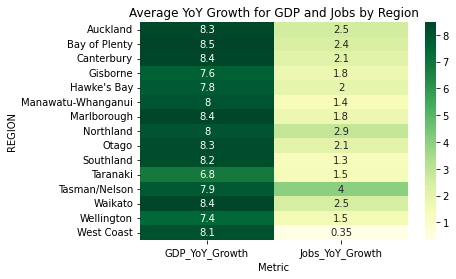

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

### Heatmap to visualise the growths in filled jobs and GDP by region ###
### Melt the DataFrame
df_melted = merged_df.melt(id_vars=['REGION'], var_name='Metric', value_name='YoY_Growth')

### Pivot the data
pivot_table = df_melted.pivot("REGION", "Metric", "YoY_Growth")

### Create the heatmap
sns.heatmap(pivot_table, annot=True, cmap="YlGn")
plt.title('Average YoY Growth for GDP and Jobs by Region')
plt.show()

From the graph we can extract a couple of insights.<br>
All regions have a similar YoY GDP growth (mean of 8 with standard deviation of only 0.45).<br>
Though not all regions have a proportional increase in the YoY job numbers (mean of 2, but a much larger standard deviation of 0.83). <br> 
Supported by the summary statistics table above.<br>

We can see that the Tasman/Nelson region has the highest YoY job numbers growth amongst the regions while still having similar GDP growth suggesting there are increasing job numbers in that region so BNZ could focus on selling more business loans in that area.
The Northland region has a similar phenomenon.<br>
In contrast the West Coast region has low job numbers growth but still stable GDP growth suggesting there are fewer opportunities for BNZ to sell business loan products in that region.<br>
Due to the similar YoY GDP growth across most regions, loans in most regions can be thought of as being similarly safe.<br>

For improvements or further insights, I would suggest adding another variable to slice the data further.<br>
My thinking was creating a model for job numbers by industry and region, which could further help tailor buisness loans to specific industries.